# Multi Orbital Borophene Model from 10.1103/PhysRevB.94.165403

In [1]:
import pybinding as pb
import matplotlib.pyplot as plt
import numpy as np
import scipy

from matplotlib import gridspec

pb.pltutils.use_style()

## Define the lattice properties

In [2]:
a = 0.452
b = 0.326
z1 = 1.3 * 0.084
z2 = 1.3 * 0.031

pos1y = 0.753
pos2x = 0.185

rb = 0.0529  # [nm]
es = 0.056616  # [Ry]
ep = 0.522755 + es  # [Ry]
ry_to_ev = 13.605662285137

# mistake in the paper, the table on page 2 should be transposed
fitting_params = {
    'ss_sigma': {'e': -45.6146, 'f': 7.926, 'g': 0.770158, 'h': 0.987246},
    'sp_sigma': {'e': -1.29979, 'f': -2.54973, 'g': 1.15919, 'h': 0.864357},
    'pp_sigma': {'e': 2.89833, 'f': -7.75733, 'g': 2.28587, 'h': 0.888621},
    'pp_pi': {'e': 5.27856, 'f': 0.937117, 'g': -3.4852, 'h': 1.3349},
}

pbr1 = np.array([0, b * (pos1y - 1 / 2), -z1])
pbr2 = np.array([0, b * (3 / 2 - pos1y), -z1])
pbr3 = np.array([a / 2, b * (1 - pos1y), z1])
pbr4 = np.array([a / 2, b * pos1y, z1])

pbi1 = np.array([a * pos2x, b / 2, z2])
pbi2 = np.array([a * (1 / 2 - pos2x), 0, -z2])
pbi3 = np.array([a * (1 / 2 + pos2x), 0, -z2])
pbi4 = np.array([a * (1 - pos2x), b / 2, z2])

In [3]:
def directional_cosine(distance_vector, direction):
    """
    Compute directional cosine

    Parameters
    ----------
    distance_vector: distance vector between the two sites
    direction: chosen direction

    Returns
    -------
    Value of directional cosine

    """
    distance = np.linalg.norm(distance_vector)
    if direction == 'x':
        return distance_vector[0] / distance
    if direction == 'y':
        return distance_vector[1] / distance
    if direction == 'z':
        return distance_vector[2] / distance
    return Exception('Wrong direction')

In [4]:
def tc_int(distance_vector, integral_type):
    """
    Compute two center integral

    Parameters
    ----------
    distance_vector: distance vector between the two sites
    integral_type: type of the integral ss_sigma, sp_sigma, pp_sigma, pp_pi

    Returns
    -------
    Value of the hopping parameter
    """
    # take parameters for the desired integral type
    fitting_terms = fitting_params[integral_type]
    # compute the distance from a distance vector
    distance = np.linalg.norm(distance_vector)
    # extract parameters
    e = fitting_terms['e']
    f = fitting_terms['f']
    g = fitting_terms['g']
    h = fitting_terms['h']

    return (e + f * distance / rb + g * (distance / rb) ** 2) * np.exp(-h ** 2 * distance / rb)

In [5]:
def hop(dv):
    """
    Compute the hopping integral matrix between two atom

    Parameters
    ----------
    dv: distance vector between the two sites

    Returns
    -------
    A matrix with all hopping integrals
    """
    dcos_x = directional_cosine(dv, 'x')
    dcos_y = directional_cosine(dv, 'y')
    dcos_z = directional_cosine(dv, 'z')

    ess = tc_int(dv, 'ss_sigma')
    espx = dcos_x * tc_int(dv, 'sp_sigma')
    espy = dcos_y * tc_int(dv, 'sp_sigma')
    espz = dcos_z * tc_int(dv, 'sp_sigma')

    epxpx = dcos_x ** 2 * tc_int(dv, 'pp_sigma') + (1 - dcos_x ** 2) * tc_int(dv, 'pp_pi')
    epypy = dcos_y ** 2 * tc_int(dv, 'pp_sigma') + (1 - dcos_y ** 2) * tc_int(dv, 'pp_pi')
    epzpz = dcos_z ** 2 * tc_int(dv, 'pp_sigma') + (1 - dcos_z ** 2) * tc_int(dv, 'pp_pi')

    epxpy = dcos_x * dcos_y * tc_int(dv, 'pp_sigma') - dcos_x * dcos_y * tc_int(dv, 'pp_pi')
    epxpz = dcos_x * dcos_z * tc_int(dv, 'pp_sigma') - dcos_x * dcos_z * tc_int(dv, 'pp_pi')
    epypz = dcos_y * dcos_z * tc_int(dv, 'pp_sigma') - dcos_y * dcos_z * tc_int(dv, 'pp_pi')

    # epxpy = epypx
    # but the spx and pxs are not equivalent
    # s->px Vspx but px->-Vspx!!!
    return [[  ess,  espx,  espy,  espz],
            [-espx, epxpx, epxpy, epxpz],
            [-espy, epxpy, epypy, epypz],
            [-espz, epxpz, epypz, epzpz]]

In [6]:
def borophene():
    """
    Create a lattice of 8-Pmmn borophene

    Returns
    -------
    Pybinding lattice object
    """

    # lattice vectors
    a1 = np.array([a, 0, 0])
    a2 = np.array([0, b, 0])
    lat = pb.Lattice(a1=a1, a2=a2)

    # and add the ridge atoms
    lat.add_sublattices(
        ('BR1', pbr1, [es, ep, ep, ep])
    )

    # add the inner atoms
    lat.add_sublattices(
        ('BI1', pbi1, [es, ep, ep, ep])
    )

    # all other ridge atoms are equivalent, add_aliases takes that into account when creating the model
    lat.add_aliases(('BR2', 'BR1', pbr2),
                    ('BR3', 'BR1', pbr3),
                    ('BR4', 'BR1', pbr4)
                    )

    # all other inner atoms are equivalent, add_aliases takes that into account when creating the model
    lat.add_aliases(('BI2', 'BI1', pbi2),
                    ('BI3', 'BI1', pbi3),
                    ('BI4', 'BI1', pbi4)
                    )
    # adding hopping terms
    # t11x
    lat.add_hoppings(
        ([0, 0], 'BR1', 'BR2', hop(pbr2 - pbr1)),
        ([0, 1], 'BR4', 'BR3', hop(pbr3 - pbr4 + a2)),
                    )
    # t11n
    lat.add_hoppings(
        ([0, 1], 'BR2', 'BR1', hop(pbr1 - pbr2 + a2)),
        ([0, 0], 'BR3', 'BR4', hop(pbr4 - pbr3)),
                    )

    # t22n
    lat.add_hoppings(
        ([0, 0], 'BI1', 'BI2', hop(pbi2 - pbi1)),
        ([0, 1], 'BI1', 'BI2', hop(pbi2 - pbi1 + a2)),
        ([0, 0], 'BI4', 'BI3', hop(pbi3 - pbi4)),
        ([0, 1], 'BI4', 'BI3', hop(pbi3 - pbi4 + a2)),
                    )

    # t22x
    lat.add_hoppings(
        ([-1, 0], 'BI1', 'BI4', hop(pbi4 - pbi1 - a1)),
        ([0 , 0], 'BI2', 'BI3', hop(pbi3 - pbi2))
                    )

    # t12s
    lat.add_hoppings(
        ([0 , 0], 'BR1', 'BI1', hop(pbi1 - pbr1)),
        ([-1, 0], 'BR1', 'BI4', hop(pbi4 - pbr1 - a1)),
        ([0 , 0], 'BR2', 'BI1', hop(pbi1 - pbr2)),
        ([-1, 0], 'BR2', 'BI4', hop(pbi4 - pbr2 - a1)),
        ([0 , 0], 'BR3', 'BI2', hop(pbi2 - pbr3)),
        ([0 , 0], 'BR3', 'BI3', hop(pbi3 - pbr3)),
        ([0 , 1], 'BR4', 'BI2', hop(pbi2 - pbr4 + a2)),
        ([0 , 1], 'BR4', 'BI3', hop(pbi3 - pbr4 + a2)),
                    )

    # t12l
    lat.add_hoppings(
        ([0 , 0], 'BR1', 'BI2', hop(pbi2 - pbr1)),
        ([-1, 0], 'BR1', 'BI3', hop(pbi3 - pbr1 - a1)),
        ([0 , 1], 'BR2', 'BI2', hop(pbi2 - pbr2 + a2)),
        ([-1, 1], 'BR2', 'BI3', hop(pbi3 - pbr2 - a1 + a2)),
        ([0 , 0], 'BR3', 'BI1', hop(pbi1 - pbr3)),
        ([0 , 0], 'BR3', 'BI4', hop(pbi4 - pbr3)),
        ([0 , 0], 'BR4', 'BI1', hop(pbi1 - pbr4)),
        ([0 , 0], 'BR4', 'BI4', hop(pbi4 - pbr4)),
                    )

    # set minimal number of neighbours for each site, useful when making a finite size system
    lat.min_neighbors = 1
    return lat

In [7]:
def plot_system(model):
    """
    Plot the lattice and the system

    Parameters
    ----------
    model: desired system
    """

    plt.subplot(311)
    model.lattice.plot(axes='xy')
    plt.subplot(312)
    model.lattice.plot(axes='xz')
    plt.subplot(313)
    model.lattice.plot(axes='yz')
    plt.show()

    model.plot()
    plt.show()

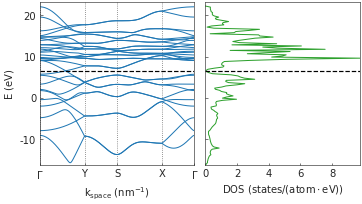

In [8]:
lattice = borophene()
model = pb.Model(lattice,
                 pb.translational_symmetry(True, True)
                 )

b1, b2 = model.lattice.reciprocal_vectors()
X = b1[0:2] / 2
Y = b2[0:2] / 2
G = [0, 0]
S = X + Y

path = [G, Y, S, X, G]

solver = pb.solver.lapack(model)
bands = solver.calc_bands(*path, step=0.05)
bands.energy *= ry_to_ev

e_min = -1.2 * ry_to_ev
e_max = 1.7 * ry_to_ev
energy = np.linspace(e_min, e_max, 2000)
# this is the energy of the Dirac point
e_dirac = 0.482 * ry_to_ev
# cuts a size_x, size_y rectangle with periodic boundary conditions
size_x = size_y = 50
broadening = 5e-3
num_random = 16
# notice that size_x and size_y enters the translational_symmetry function, which is along the directions a1 and a2
# model will cut a square of this size of pb.rectangle(2 * size_x, 2 * size_y) and apply periodic boundary conditions
model = pb.Model(borophene(),
                 pb.rectangle(2 * size_x, 2 * size_y),
                 pb.translational_symmetry(size_x, size_y))
kpm = pb.kpm(model, silent=True)
dos = kpm.calc_dos(energy, broadening=broadening, num_random=num_random)
dos.data /= model.system.num_sites
dos.variable *= ry_to_ev
# plot the data
fig = plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.06, right=0.95, wspace=0.2, hspace=0.05)
lambda_block = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 0], wspace=0.07, hspace=0.05)

ax = fig.add_subplot(lambda_block[0, 0])
plt.sca(ax)
kwargs = pb.results.with_defaults(dict(), color="tab:blue", lw=1)
# bands.plot(point_labels=[r'$\Gamma$', 'Y', 'S', 'X', r'$\Gamma$'])
k_space = bands.k_path.as_1d()
ax.plot(k_space, bands.energy, **kwargs)
ax.axhline(y=e_dirac, xmin=0, xmax=bands.k_path.point_indices[-1], linestyle='--', color='k')
ax.set_xlabel(r'$k_{space}~{\rm (nm^{-1})}$')
ax.set_ylabel(r'$E~{\rm (eV)}$')
# Draw vertical lines at significant points. Because of the `transLimits.transform`,
# this must be the done last, after all other plot elements are positioned.
for idx in bands.k_path.point_indices:
    ax.axvline(k_space[idx], ymax=e_max, color="0.4", lw=0.8, ls=":", zorder=-1)
plt.xticks(bands.k_path.point_indices, [r'$\Gamma$', 'Y', 'S', 'X', r'$\Gamma$'])
plt.ylim([e_min, e_max])
plt.xlim([bands.k_path.point_indices[0], bands.k_path.point_indices[-1]])

ax = fig.add_subplot(lambda_block[0, 1])
plt.sca(ax)
kwargs = pb.results.with_defaults(dict(), color="tab:green", lw=1)
ax.plot(dos.data, dos.variable, **kwargs)
ax.axhline(y=e_dirac, xmin=0, xmax=bands.k_path.shape[0], linestyle='--', color='k')
ax.set_xlabel(r'$DOS~({\rm states / (atom \cdot eV)})$')
ax.set_ylim([e_min, e_max])
ax.set_yticklabels([])
# close to the edge of the spectrum kpm tends to deviate and produces some NaN values
dos.data[np.isnan(dos.data)] = np.zeros_like(np.isnan(dos.data).flatten().shape[0])
ax.set_xlim([0, np.max(dos.data)])
plt.show()